**Import the libraries**

In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms, models
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
from torch import optim
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn as nn
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix

In [2]:
train_data = r"./chest_xray/train" # Path of my training dataset
valid_data = r"./chest_xray/val"
test_data = r"./chest_xray/test"

**Need to set up the path**

In [3]:
path = Path(train_data)

# To list the contents of the library
contents = list(path.glob('*')) # List all files and the directories

'''
Additionally, we can use the len(contents) command to count the number of files in the folder.
'''
for item in contents:
    print(item)

chest_xray/train/NORMAL
chest_xray/train/PNEUMONIA


**Load the data for the training**

In [4]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the image
    transforms.ToTensor(), # Convert images to the pytorch tensors
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [5]:
# Load the data using the ImageFolder
train_dataset = datasets.ImageFolder(root = train_data, transform = transform)

# Create a DataLoader for the dataset
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 4)

In [6]:
# Loading Validation and test dataset

val_dataset = datasets.ImageFolder(root = valid_data, transform = transform)
test_dataset = datasets.ImageFolder(root = test_data, transform = transform)

# Create a DataLoader for the val and test dataset 
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, num_workers = 4)

**Data Exploration**

**Define the class name**

In [7]:
class_names = train_dataset.classes

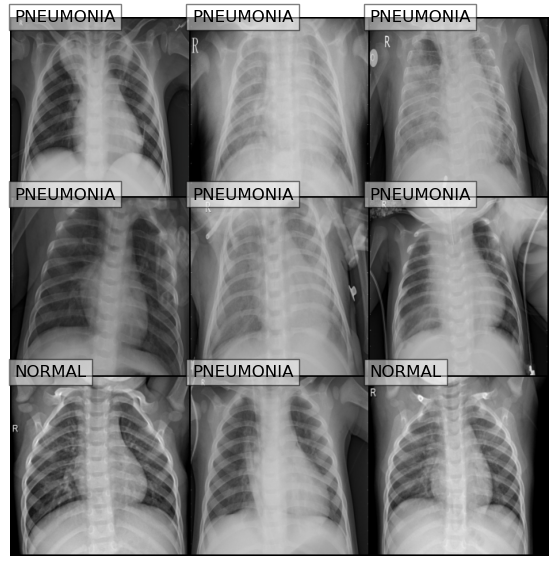

In [8]:
def imshow(img):
    img = img/2 + 0.5 # To unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Convert from the tensor
    plt.axis('off') # Hide axis
    plt.show()

    for i in range(len(labels)):
        print(f"Label: {class_names[labels[i]]}")
    
    

# Get a batch of the training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Limit the number of images to display
num_images_to_display = min(9, len(images))
images = images[:num_images_to_display]
labels = labels[:num_images_to_display]

# Define unnormalize the images
def unnormalize(image, mean, std):
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    return image

# Unnormalize using the imagenet statistics
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# images = [unnormalize(image, mean, std) for image in images]
images = torch.stack([unnormalize(image, mean, std) for image in images])

# Create a grid from the batch
grid = make_grid(images, nrow = 3) # nrow = 3 for the 3 rows of the image

# Plot the image
plt.figure(figsize = (7, 7))
npimg = np.transpose(grid.numpy(), (1, 2, 0))
plt.imshow(npimg)
plt.axis('off')

batch_size = images.size(0)
for i in range(batch_size):
    label = class_names[labels[i]]
    plt.text(x = i % 3 * 224 + 5, y = i // 3 * 224 + 5, s = label, 
             color = 'black', fontsize = 12, bbox = dict(facecolor = 'white', alpha = 0.5) )

plt.show()
    

**Load the pre-trained Res-Net50 model**

In [10]:
# model = models.resnet50(pretrained = True)
model = models.resnet50(weights = ResNet50_Weights.IMAGENET1K_V1)

# Modify the finally fully connected layer to match the number of classes in your dataset
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # Since there are 2 features in our dataset

**Define the Loss function and optimizer**

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

**Identify the learning rate**

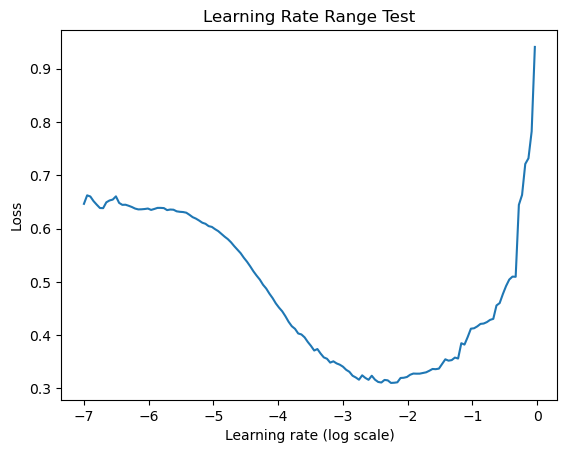

In [14]:
# Define the learning rate range test functions
# num_epochs = 5 # Number of epochs to train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

def lr_range_test(model, train_loader, criterion, optimizer, init_value = 1e-7, final_value = 10, beta = 0.98):
    num = len(train_loader) - 1
    mult = (final_value /init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.0
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []

    for inputs, labels in train_loader:
        batch_num +=1
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # compute the smoothed loss
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)

        # Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses

        # Record the best loss
        if smoothed_loss < best_loss or batch_num == 1:
            best_loss = smoothed_loss

        # Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))

        # Back propagation
        loss.backward()
        optimizer.step()

        # Update the learning rate
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr

    return log_lrs, losses


# Learn the learning rate range test
log_lrs, losses = lr_range_test(model, train_loader, criterion, optimizer)

# Plot the learning rate vs Loss
plt.plot(log_lrs, losses)
plt.xlabel('Learning rate (log scale)')
plt.ylabel('Loss')
plt.title("Learning Rate Range Test")
plt.show()

**Training and testing the model**

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.9)

In [16]:
# First Training phase: Training with OneCycleLR

scheduler = OneCycleLR(optimizer, max_lr = 1e-1, steps_per_epoch = len(train_loader), epochs = 4)
num_epochs = 4

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs} completed.")

Epoch 1/4 completed.
Epoch 2/4 completed.
Epoch 3/4 completed.
Epoch 4/4 completed.


In [17]:
# Second Training Phase: Fixed learning rate
optimizer = optim.SGD(model.parameters(), lr = 1e-1, momentum = 0.9)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} completed.")

Epoch 1/20 completed.
Epoch 2/20 completed.
Epoch 3/20 completed.
Epoch 4/20 completed.
Epoch 5/20 completed.
Epoch 6/20 completed.
Epoch 7/20 completed.
Epoch 8/20 completed.
Epoch 9/20 completed.
Epoch 10/20 completed.
Epoch 11/20 completed.
Epoch 12/20 completed.
Epoch 13/20 completed.
Epoch 14/20 completed.
Epoch 15/20 completed.
Epoch 16/20 completed.
Epoch 17/20 completed.
Epoch 18/20 completed.
Epoch 19/20 completed.
Epoch 20/20 completed.


In [18]:
# Unfreeze the model for fine tuning
for param in model.parameters():
    param.requires_grad = True

In [19]:
# Final Fine tuning
optimizer = optim.SGD(model.parameters(), lr = 1e-4, momentum = 0.9)
scheduler = OneCycleLR(optimizer, max_lr = 1e-3, steps_per_epoch = len(train_loader), epochs = 10)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs} completed.")

Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.


**Generate the confusion matrix**

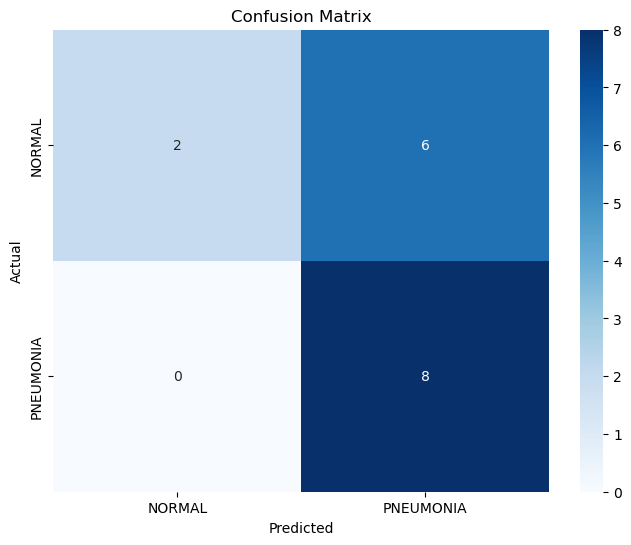

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []

# set the model to the evaluation mode
model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['NORMAL', 'PNEUMONIA'], yticklabels = ['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Prediction on a single image**

In [21]:
from PIL import Image

# Load the image
image_path = './chest_xray/test/NORMAL/IM-0001-0001.jpeg'
image = Image.open(image_path).convert('RGB')

# Preprocess the image
image = transform(image).unsqueeze(0) #Add the batch dimension

# Move the image to the same device as the model
image = image.to(device)

# Make a prediction
model.eval()
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

# Decode the prediction
class_names = ['Normal', 'Pneumonia']
print(f"Predicted: {class_names[predicted.item()]}")

Predicted: Pneumonia
